In [1]:
from zipfile import ZipFile
from io import BytesIO
import json
import glob
import urllib

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
from tensorflow.keras.preprocessing.text import Tokenizer
from scipy.spatial.distance import pdist, cdist, squareform
from sklearn.decomposition import PCA


In [19]:
# GLOBAL VARS
GLOVE_URL = 'http://nlp.stanford.edu/data/glove.6B.zip'
EMBEDDING_DIM = 100
DATA_FILE = "datafile.csv"
DATA_URL = "https://raw.githubusercontent.com/sagarkar10/Covid19/master/poc_data.csv"

# Derived Vars
embeddings_file = 'glove.6B.{0}d.txt'.format(EMBEDDING_DIM)
word2vec_output_file = 'resources/{0}.word2vec'.format(embeddings_file)


In [168]:
# # using only biorxiv_medrxiv for POC, write data from csv
# fl = glob.glob("../data/biorxiv_medrxiv/biorxiv_medrxiv/*.json")

# def get_data_v1(fl):
#     aggregator = []
#     for each in fl:
#         with open(each, "r") as fr:
#             data = json.load(fr)
#             paper_id = data.get("paper_id")
#             title = data.get("metadata").get("title")
#             abstract = ''.join([x.get("text") for x in data.get("abstract")])
#             # abstract paragraphs may not be in order, ignoring that fact.
#             aggregator.append({"paper_id":paper_id, "title":title, "abstract":abstract})
#     return pd.DataFrame(aggregator)
# df = get_data_v1(fl)
# df.to_csv("data.csv", index=False)

# # generate glove files
# resp = urllib.request.urlopen(GLOVE_URL)
# zipfile = ZipFile(BytesIO(resp.read()))
# print(zipfile.namelist())

# # Write embeddings to file
# zipfile.extract(embeddings_file)
# glove2word2vec(embeddings_file, word2vec_output_file)

In [20]:
glove = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

In [68]:
# Load data from GitHub to this notebook's local drive
response = urllib.request.urlopen(DATA_URL)
html = response.read()
with open(DATA_FILE, 'wb') as fp:
    fp.write(html)
df = pd.read_csv(DATA_FILE)

In [69]:
df.head()

,abstract,paper_id,title
0,New anti-AIDS treatments must be continually d...,f905f78b32f63c6d14a79984dfb33f1b358b8ab4,Multimerization of HIV-1 integrase hinges on c...
1,Rationale: Several studies have estimated basi...,abcfffafab399149d4adadd6bb458c4994e2025d,Time-varying transmission dynamics of Novel Co...
2,Summary Statement: DUX4 is thought to mediate ...,0cb9c296684ca5e71462d825cab2827854a01544,p53 is not necessary for DUX4 pathology
3,"emerged in late 2019 1,2 . Initial outbreaks i...",9bbfd3d34ee18ea1b9f4669331a6cee9c5992893,Virological assessment of hospitalized cases o...
4,A novel coronavirus (SARS-CoV-2) first detecte...,1218f278a4f8d83dac14b23c8f698062812ef9d5,Potential impact of seasonal forcing on a SARS...


In [86]:
with open("stopwords.txt", 'r') as fp:
    STOP_WORDS = fp.read().split('\n')
    
def vectorize_sents(sents, g_em):
    ret_sents = []
    for each in sents:
        ret_sents.append(vectorize_sent(each, g_em))
    return ret_sents

def vectorize_sent(sent, g_em):
    sent_vec = np.zeros(EMBEDDING_DIM)
    numw = 0
    for w in sent:
        if w.lower() in STOP_WORDS:
            continue
        try:
            sent_vec = np.add(sent_vec, g_em.get_vector(w))
            numw+=1
        except:
            pass
    return sent_vec / np.sqrt(sent_vec.dot(sent_vec))

def process_df(df, glove):
    df = df.dropna()
    df = df.drop(df[(df.title=="") | (df.abstract=="")].index).reset_index(drop=True)
#     X = np.concatenate([df[~(df.title=="") & ~(df.title.isna())].title.values, df[~(df.abstract=="") & ~(df.abstract.isna())].abstract.values])
    X = np.concatenate([df.title.values, df.abstract.values])
    FILTERS = "!\"'#$%&()*+,-./:;<=>?@[\\]^_`{|}~"
    LOWER = True
    CHAR_LEVEL = False
    X_tokenizer = Tokenizer(filters=FILTERS, lower=LOWER, char_level=CHAR_LEVEL, oov_token=None)
    X_tokenizer.fit_on_texts(X)
    X_processed_t, X_processed_a  = np.array(X_tokenizer.texts_to_sequences(df.title.values)), np.array(X_tokenizer.texts_to_sequences(df.abstract.values))
    title_tokens, abstract_tokens = X_tokenizer.sequences_to_texts(X_processed_t), X_tokenizer.sequences_to_texts(X_processed_a)
    df["title_vect"], df["abstract_vect"] = vectorize_sents(title_tokens, glove, ), vectorize_sents(abstract_tokens, glove)
    return df, X_tokenizer

In [87]:
df, X_tokenizer = process_df(df, glove)

In [106]:
def get_most_similar(query_title):
    print(f"Query Title: \t\t {query_title}")
    vp = np.array(X_tokenizer.texts_to_sequences([query_title]))
    vp_ = X_tokenizer.sequences_to_texts(vp)
    print(f"processed Query Title:\t {vp_[0]}")
    v0 = vectorize_sent(vp_[0], glove)
#     print(f"Vector representation: {v0}")
    idx = cdist([v0], np.stack( df["title_vect"].values, axis=0 ), metric='cosine')[0].argsort()[:5]
    top_5 = df.title.loc[idx].values
    print(f"Top 5 Similar titles:\n {top_5}")

In [107]:
get_most_similar('Real-Time Estimation of the Risk of Death from Novel Coronavirus (COVID-19)')

Query Title: 		 Real-Time Estimation of the Risk of Death from Novel Coronavirus (COVID-19)
processed Query Title:	 real time estimation of the risk of death from novel coronavirus covid 19
Top 5 Similar titles:
 ['Real-Time Estimation of the Risk of Death from Novel Coronavirus (COVID-19) Infection: Inference Using Exported Cases'
 'Estimation of the epidemic properties of the 2019 novel coronavirus: A mathematical modeling study'
 'Rapid Detection of Novel Coronavirus (COVID-19) by Reverse Transcription- Loop-Mediated Isothermal Amplification'
 'Rigidity, normal modes and flexible motion of a SARS-CoV-2 (COVID- 19) protease structure'
 'Assessing the impact of reduced travel on exportation dynamics of novel coronavirus infection (COVID-19)']


In [108]:
get_most_similar('Real-Time Estimation of the Risk of Death from Novel Coronavirus')

Query Title: 		 Real-Time Estimation of the Risk of Death from Novel Coronavirus
processed Query Title:	 real time estimation of the risk of death from novel coronavirus
Top 5 Similar titles:
 ['Title: Genome Detective Coronavirus Typing Tool for rapid identification and characterization of novel coronavirus genomes Short title: Automated tool for phylogenetic and mutational analysis of coronaviruses genomes'
 'Real-Time Estimation of the Risk of Death from Novel Coronavirus (COVID-19) Infection: Inference Using Exported Cases'
 'Role of temperature and humidity in the modulation of the doubling time of COVID-19 cases'
 'Comparative analyses of SAR-CoV2 genomes from different geographical locations and other coronavirus family genomes reveals unique features potentially consequential to host-virus interaction and pathogenesis'
 'In-silico immune cell deconvolution of the airway proteomes of infants with pneumonia reveals a link between reduced airway eosinophils and an increased risk o

In [ ]:
df.head()

In [134]:
distances = pdist(np.stack( df["title_v"].sample(30).values, axis=0 ), metric='cosine')
dist_matrix = squareform(distances)

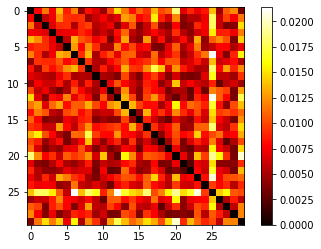

In [135]:
# cosine distance, not similarity
plt.imshow(dist_matrix, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()